# Project: Wrangle and Analyze Data
- Felipe Rocha

## 1. Gathering

### 1.1 The WeRateDogs Twitter archive
This file was given to me and so I only needed to download it manually. Now, I will load in my environment:

In [3]:
import pandas as pd #pandas to read the file

In [4]:
we_rate_dogs_archive = pd.read_csv('twitter_archive_enhanced.csv')

In [5]:
we_rate_dogs_archive.head(2) #just a guick glance to see if it was correctly loaded

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### 1.2 The tweet image predictions
- This file is hosted in a given url, which I should programatically download via the `requests` package

In [6]:
import requests

In [7]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [8]:
tweet_images = requests.get(url) #getting the url

In [9]:
tweet_images.status_code #checking if OK

200

In [10]:
import io #to help pandas decoding
tweet_images = tweet_images.content #establishing the content
tweet_images = pd.read_csv(io.StringIO(tweet_images.decode('utf-8')), '\t') #pandas object

C:\Users\felipe.rocha_ifood\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
tweet_images.head(3) #checking if OK

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [12]:
tweet_images.to_csv('image_predictions.tsv')
#for safety, a backup

### 1.3 Additional Twitter Data

In [13]:
import json

aditional_tweet = pd.read_json('tweet_json.txt', lines = True) #reading the json line by line as requested

aditional_tweet['tweet_id'] = aditional_tweet['id'] #changing the id name to tweet_id

aditional_tweet = aditional_tweet[['tweet_id', 
                                   'favorite_count',
                                   'retweet_count']] #selecting the cols I am going to use

## 2. Assessing 

### 2.1 WeRateDogs


In [14]:
# Visual Assessment
we_rate_dogs_archive.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


- Quality:
    - Existence of missing data
    - Missing data labeled both as NaN and as None
- Tidyness:
    - The info on dogs should be in a different table than the info on tweets
    - The info on metadata like retweet status, urls sources should be in a different table than the info on tweets

In [15]:
# Programmatic assessment
we_rate_dogs_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

- Quality:
    - Existence of missing data in: 
        - `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_url`
    - Missing data labeled not only named as NaN (cols above) but also as None in:
        - `doggo`, `floofer`, `pupper`, `puppo`

In [16]:
# Programmatic assessment
we_rate_dogs_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

- Quality:
    - Existence of missing data in: 
        - `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_url`
    - Missing data labeled not only named as NaN (cols above) but also as None in:
        - `doggo`, `floofer`, `pupper`, `puppo`
    - All the 'id' columns should be a string object not an integer/float class
    - All the 'timestamp' columns should be a date class not an object

In [17]:
# Programmatic assessment
we_rate_dogs_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


- Quality:
    - Missing data in: 
        - `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_url`
    - Missing data  not only named as NaN (cols above) but also as None in:
        - `doggo`, `floofer`, `pupper`, `puppo`
    - All the 'id' columns should be a string object not an integer/float class
    - All the 'timestamp' columns should be a date class not an object
    - `rating_numerator` and `rating_denominator` seems to have wrong max values

### 2.2 Tweet Images

In [18]:
# Visual Assessment
tweet_images.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


- Quality:
    - Some column names are not informative like p1, p1_conf, p1_dog
    - In `p1`, `p2`, `p3` there are not standardized (like lowercase and capital case)

In [19]:
# Programmatic assessment
tweet_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
# Programmatic assessment
tweet_images.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

- Quality:
    - Some column names are not informative like p1, p1_conf, p1_dog
    - In `p1`, `p2`, `p3` there are not standardized (like lowercase and capital case)
    - `tweet_id` should be a string object not integer

In [21]:
# Programmatic assessment
tweet_images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


- Quality:
    - Some column names are not informative like p1, p1_conf, p1_dog
    - In `p1`, `p2`, `p3` there are not standardized (like lowercase and capital case)
    - `tweet_id` should be a string object not integer

### 2.3 Additional Twitter Data

In [22]:
# Visual Assessment
aditional_tweet.head(5)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [23]:
# Programmatic assessment
aditional_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


- Quality:
    - Up till now, the only issue here is the `tweet_id` which is an integer and should be an object

In [24]:
aditional_tweet.describe()

,tweet_id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


- Quality:
    - Up till now, the only issue here is the `tweet_id` which is an integer and should be an object

### 2.4 Assessment Report

- **QUALITY**
    - **We Rate Dogs dataset**
        - Missing data in: 
            - `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_url`
        - Missing data  not only named as NaN (cols above) but also as None in:
            - `doggo`, `floofer`, `pupper`, `puppo`
        - All the 'id' columns should be a string object not an integer/float class
        - All the 'timestamp' columns should be a date class not an object
        - `rating_numerator` seems to have wrong max values
        - `rating_denominator` seems to have wrong max values
    - **Tweet Images**
         - Some column names are not informative like p1, p1_conf, p1_dog
         - In `p1`, `p2`, `p3` there are not standardized (like lowercase and capital case)
         - `tweet_id` should be a string object not integer
    - **Additional Tweet**
        - The only issue here is the `tweet_id` which is an integer and should be an object
        
- **TIDYNESS**
    - **We Rate Dogs dataset**
       - The info on dogs should be in a different table than the info on tweets
       - The info on metadata like retweet status, urls sources should be in a different table than the info on tweets

## 3. Cleaning

- First, copying the original datasets:

In [25]:
we_rate_dogs_cleaned = we_rate_dogs_archive.copy()
tweet_images_cleaned = tweet_images.copy()
aditional_tweet_cleaned = aditional_tweet.copy()

- Now, let the cleaning phase begin:

### 3.1 Define

- **QUALITY**
    - **We Rate Dogs dataset**
 
        - Change all the 'id' columns to a string object
        - Change all the 'timestamp' columns to a date class
        - `rating_numerator` seems to have wrong max values, use 1-10 instead
        - `rating_denominator` seems to have wrong max values, use 1-10 instead

    - **Tweet Images**
         - Some column names are not informative like p1, p1_conf, p1_dog change them to proper names
         - In `p1`, `p2`, `p3` there are not standardized values (like lowercase and capital case). Make them equal.
         - Change `tweet_id` to a string object
    - **Additional Tweet**
        - The only issue here is the `tweet_id` which is an integer and should be an object, let's change that
        
- **TIDYNESS**
    - **We Rate Dogs dataset**
       - The info on dogs should be in a different table than the info on tweets, let's drop the unnecessary cols
       - The info on metadata like retweet status, urls sources will be in a different table than the info on tweets, let's remove the  columns from this dataset and put into another

### 3.2 Code

- Let's first deal with the tidyness issues:

In [26]:
# Copying the dataset and including only the needed cols

tweet_meta = we_rate_dogs_cleaned.copy()
tweet_meta = tweet_meta[['in_reply_to_status_id', 'in_reply_to_status_id',
                         'retweeted_status_id', 'retweeted_status_user_id',
                         'retweeted_status_timestamp', 'expanded_urls', 'source']]

In [27]:
# Copying the dataset and including only the needed cols

dogs_info = we_rate_dogs_cleaned.copy()
dogs_info = dogs_info[['name', 'doggo', 
                       'floofer', 'pupper', 'puppo']]

In [28]:
# Now, selecting only the needed cols for this dataset

we_rate_dogs_cleaned = we_rate_dogs_cleaned[['tweet_id',  'timestamp', 
                                             'text',  'rating_numerator', 'rating_denominator', 
                                             ]]

- **QUALITY**
    - **We Rate Dogs dataset**

        - Change all the 'id' columns to a string object
        - Change all the 'timestamp' columns to a date class
        - `rating_numerator` seems to have wrong max values, use 1-10 instead
        - `rating_denominator` seems to have wrong max values, use 1-10 instead
    - **Tweet Images**
         - Some column names are not informative like p1, p1_conf, p1_dog change them to proper names
         - In `p1`, `p2`, `p3` there are not standardized values (like lowercase and capital case). Make them equal.
         - Change `tweet_id` to a string object
    - **Additional Tweet**
        - The only issue here is the `tweet_id` which is an integer and should be an object, let's change that
        
- **TIDYNESS**
    - **We Rate Dogs dataset**
       - ✔️ The info on dogs should be in a different table than the info on tweets, let's drop the unnecessary cols
       - ✔️ The info on metadata like retweet status, urls sources will be in a different table than the info on tweets, let's remove the  columns from this dataset and put into another

- Now to the quality issues

In [29]:
# Correcting the tweet_id from additional tweet
aditional_tweet_cleaned['tweet_id'] = aditional_tweet_cleaned['tweet_id'].astype('str')

In [30]:
# Correcting the tweet_id from tweet images
tweet_images_cleaned['tweet_id'] = tweet_images_cleaned['tweet_id'].astype('str')

In [31]:
# Correcting the tweet_id from we_rate_dogs
we_rate_dogs_cleaned['tweet_id'] = we_rate_dogs_cleaned['tweet_id'].astype('str')

- A quick verification of what we have done up till now

- **QUALITY**
    - **We Rate Dogs dataset**
        - ✔️ Change all the 'id' columns to a string object
        - Change all the 'timestamp' columns to a date class
        - `rating_numerator` seems to have wrong max values, use 1-10 instead
        - `rating_denominator` seems to have wrong max values, use 1-10 instead
    - **Tweet Images**
         - Some column names are not informative like p1, p1_conf, p1_dog change them to proper names
         - In `p1`, `p2`, `p3` there are not standardized values (like lowercase and capital case). Make them equal.
         - ✔️ Change `tweet_id` to a string object
    - **Additional Tweet**
        - ✔️ The only issue here is the `tweet_id` which is an integer and should be an object, let's change that
        
- **TIDYNESS**
    - **We Rate Dogs dataset**
       - ✔️ The info on dogs should be in a different table than the info on tweets, let's drop the unnecessary cols
       - ✔️ The info on metadata like retweet status, urls sources will be in a different table than the info on tweets, let's remove the  columns from this dataset and put into another

Let's check the p1, p2, p3 values

In [32]:
tweet_images_cleaned.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald_eagle              1
lorikeet                1
orange                  1
Name: p1, Length: 378, dtype: int64

In [33]:
tweet_images_cleaned['p1'] = tweet_images_cleaned['p1'].str.lower().str.replace('_', ' ') #lower case and separating names

In [34]:
tweet_images_cleaned['p1'].value_counts() #just checking

golden retriever      150
labrador retriever    100
pembroke               89
chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald eagle              1
lorikeet                1
orange                  1
Name: p1, Length: 378, dtype: int64

In [35]:
tweet_images_cleaned['p2'] = tweet_images_cleaned['p2'].str.lower().str.replace('_', ' ') #lower case and separating names

In [36]:
tweet_images_cleaned['p2'].value_counts() #just checking

labrador retriever    104
golden retriever       92
cardigan               74
chihuahua              44
pomeranian             42
                     ... 
horse cart              1
tray                    1
pier                    1
red fox                 1
bagel                   1
Name: p2, Length: 404, dtype: int64

In [37]:
tweet_images_cleaned['p3'] = tweet_images_cleaned['p3'].str.lower().str.replace('_', ' ') #lower case and separating names

In [38]:
tweet_images_cleaned['p3'].value_counts() #just checking

labrador retriever    79
chihuahua             58
golden retriever      48
eskimo dog            38
kelpie                35
                      ..
ox                     1
assault rifle          1
axolotl                1
pot                    1
banana                 1
Name: p3, Length: 408, dtype: int64

- A quick verification:

- **QUALITY**
    - **We Rate Dogs dataset**
        - ✔️ Change all the 'id' columns to a string object
        - Change all the 'timestamp' columns to a date class
        - `rating_numerator` seems to have wrong max values, use 1-10 instead
        - `rating_denominator` seems to have wrong max values, use 1-10 instead
    - **Tweet Images**
         - Some column names are not informative like p1, p1_conf, p1_dog change them to proper names
         - ✔️ In `p1`, `p2`, `p3` there are not standardized values (like lowercase and capital case). Make them equal.
         - ✔️ Change `tweet_id` to a string object
    - **Additional Tweet**
        - ✔️ The only issue here is the `tweet_id` which is an integer and should be an object, let's change that
        
- **TIDYNESS**
    - **We Rate Dogs dataset**
       - ✔️ The info on dogs should be in a different table than the info on tweets, let's drop the unnecessary cols
       - ✔️ The info on metadata like retweet status, urls sources will be in a different table than the info on tweets, let's remove the  columns from this dataset and put into another

In [39]:
#lets us now clean some col names
tweet_images_cleaned.rename(columns = {'p1': 'first_prediction',
                                       'p1_conf': 'first_prediction_confidence_level',
                                       'p1_dog': 'is_first_prediction_a_dog_breed',
                                       'p2': 'second_prediction',
                                       'p2_conf': 'second_prediction_confidence_level',
                                       'p2_dog': 'is_second_prediction_a_dog_breed',
                                       'p3': 'third_prediction',
                                       'p3_conf': 'third_prediction_confidence_level',
                                       'p3_dog': 'is_third_prediction_a_dog_breed'
                                      }, inplace = True)

In [40]:
#Now, let me deal with changing we_rate_dog timestamp

we_rate_dogs_cleaned['timestamp'] = (pd.to_datetime(we_rate_dogs_cleaned['timestamp'], format = '%Y-%m-%d')
                                     .dt.strftime('%Y-%m-%d')
                                    )

In [41]:
we_rate_dogs_cleaned['timestamp'].value_counts()

2015-11-29    26
2015-11-28    26
2015-11-16    25
2015-12-01    24
2015-11-19    23
              ..
2016-04-17     1
2016-04-14     1
2017-02-27     1
2016-04-10     1
2016-04-27     1
Name: timestamp, Length: 608, dtype: int64

- **QUALITY**
    - **We Rate Dogs dataset**
 
        - ✔️ Change all the 'id' columns to a string object
        - ✔️ Change all the 'timestamp' columns to a date class
        - ✔️ `rating_numerator` seems to have wrong max values, use 1-10 instead
        - ✔️ `rating_denominator` seems to have wrong max values, use 1-10 instead
    - **Tweet Images**
         - ✔️ Some column names are not informative like p1, p1_conf, p1_dog change them to proper names
         - ✔️ In `p1`, `p2`, `p3` there are not standardized values (like lowercase and capital case). Make them equal.
         - ✔️ Change `tweet_id` to a string object
    - **Additional Tweet**
        - ✔️ The only issue here is the `tweet_id` which is an integer and should be an object, let's change that
        
- **TIDYNESS**
    - **We Rate Dogs dataset**
       - ✔️ The info on dogs should be in a different table than the info on tweets, let's drop the unnecessary cols
       - ✔️ The info on metadata like retweet status, urls sources will be in a different table than the info on tweets, let's remove the  columns from this dataset and put into another

In [42]:
we_rate_dogs_cleaned = we_rate_dogs_cleaned.query('rating_numerator <=10')

In [43]:
we_rate_dogs_cleaned = we_rate_dogs_cleaned.query('rating_denominator <=10')

In [44]:
we_rate_dogs_cleaned

,tweet_id,timestamp,text,rating_numerator,rating_denominator
45,883482846933004288,2017-07-08,This is Bella. She hopes her smile made you sm...,5,10
113,870726314365509632,2017-06-02,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,10,10
165,860177593139703809,2017-05-04,RT @dog_rates: Ohboyohboyohboyohboyohboyohboyo...,10,10
212,851861385021730816,2017-04-11,RT @eddie_coe98: Thanks @dog_rates completed m...,10,10
229,848212111729840128,2017-04-01,This is Jerry. He's doing a distinguished tong...,6,10
...,...,...,...,...,...
2351,666049248165822465,2015-11-16,Here we have a 1949 1st generation vulpix. Enj...,5,10
2352,666044226329800704,2015-11-16,This is a purebred Piers Morgan. Loves to Netf...,6,10
2353,666033412701032449,2015-11-15,Here is a very happy pup. Big fan of well-main...,9,10
2354,666029285002620928,2015-11-15,This is a western brown Mitsubishi terrier. Up...,7,10


### 3.3 Test

In [45]:
we_rate_dogs_cleaned.head(4)

,tweet_id,timestamp,text,rating_numerator,rating_denominator
45,883482846933004288,2017-07-08,This is Bella. She hopes her smile made you sm...,5,10
113,870726314365509632,2017-06-02,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,10,10
165,860177593139703809,2017-05-04,RT @dog_rates: Ohboyohboyohboyohboyohboyohboyo...,10,10
212,851861385021730816,2017-04-11,RT @eddie_coe98: Thanks @dog_rates completed m...,10,10


In [46]:
tweet_images_cleaned.head(4)

,tweet_id,jpg_url,img_num,first_prediction,first_prediction_confidence_level,is_first_prediction_a_dog_breed,second_prediction,second_prediction_confidence_level,is_second_prediction_a_dog_breed,third_prediction,third_prediction_confidence_level,is_third_prediction_a_dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True


In [47]:
aditional_tweet_cleaned.head(4)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964


In [48]:
dogs_info.head(4)

,name,doggo,floofer,pupper,puppo
0,Phineas,None,None,None,None
1,Tilly,None,None,None,None
2,Archie,None,None,None,None
3,Darla,None,None,None,None


In [49]:
tweet_meta.head(4)

,in_reply_to_status_id,in_reply_to_status_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,source
0,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,"<a href=""http://twitter.com/download/iphone"" r..."
1,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,"<a href=""http://twitter.com/download/iphone"" r..."
2,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,"<a href=""http://twitter.com/download/iphone"" r..."
3,NaN,NaN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,"<a href=""http://twitter.com/download/iphone"" r..."


### 3.4 Storing Data

In [50]:
we_rate_dogs_cleaned.to_csv('twitter_archive_master.csv')

In [51]:
tweet_images_cleaned.to_csv('twitter_images_cleaned.csv')

In [52]:
aditional_tweet_cleaned.to_csv('aditional_twitter.csv')

In [53]:
dogs_info.to_csv('dogs_info.csv')

## 4. Analyzing and Visualizing Data 

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Boxplot showing the Rating Numerator')

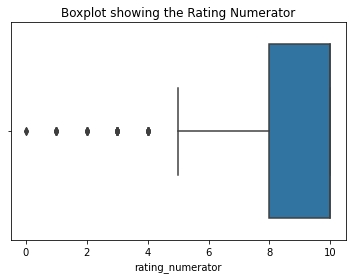

In [55]:
sns.boxplot(x = 'rating_numerator', data = we_rate_dogs_cleaned)
plt.title('Boxplot showing the Rating Numerator')

- The great majority of rating cases are between 8-10. It seems people tend not to be judgamental when it comes to puppies. That is indeed my first insight. But some cases, received less than 4. I don't think that's fair. Let me see where it happened:

In [56]:
we_rate_dogs_cleaned.query('rating_numerator <= 4').sort_values('rating_numerator')

,tweet_id,timestamp,text,rating_numerator,rating_denominator
315,835152434251116546,2017-02-24,When you're so blinded by your systematic plag...,0,10
1016,746906459439529985,2016-06-26,"PUPDATE: can't see any. Even if I could, I cou...",0,10
1869,675153376133427200,2015-12-11,What kind of person sends in a picture without...,1,10
2338,666104133288665088,2015-11-16,Not familiar with this breed. No tail (weird)....,1,10
1446,696490539101908992,2016-02-08,After reading the comments I may have overesti...,1,10
1940,673716320723169284,2015-12-07,The millennials have spoken and we've decided ...,1,10
2038,671550332464455680,2015-12-01,After 22 minutes of careful deliberation this ...,1,10
2091,670783437142401025,2015-11-29,Flamboyant pup here. Probably poisonous. Won't...,1,10
2261,667549055577362432,2015-11-20,Never seen dog like this. Breathes heavy. Tilt...,1,10
2335,666287406224695296,2015-11-16,This is an Albanian 3 1/2 legged Episcopalian...,1,2


As it seems, there are a lot of bad comments (just take a look at the tweet texts) here. Let me read some of the zero notes:

In [57]:
pd.set_option('display.max_colwidth', None)
we_rate_dogs_cleaned.query('rating_numerator == 0')

,tweet_id,timestamp,text,rating_numerator,rating_denominator
315,835152434251116546,2017-02-24,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
1016,746906459439529985,2016-06-26,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",0,10


Here it is my second insight, maybe the puppets received bad scores not necessarily for their picture itself, but for some scam/fraud being made by the owner of the post. Maybe the world is not such a dark place. My third insight involved the puppets names. I want to see what was the most popular name

In [58]:
dogs_info[['name']].value_counts()

name    
None        745
a            55
Charlie      12
Cooper       11
Oliver       11
           ... 
Kramer        1
Cheesy        1
Chaz          1
Kulet         1
Kingsley      1
Length: 957, dtype: int64

Charlie this is the most popular name. I always wanted a dog named Charlie. So, this is my third insight